In [ ]:
import pandas as pd

X_train = pd.read_csv("../data/prep/X_train.csv")
y_train = pd.read_csv("../data/prep/y_train.csv")["item_cnt_month"]

X_valid = pd.read_csv("../data/prep/X_valid.csv")
y_valid = pd.read_csv("../data/prep/y_valid.csv")["item_cnt_month"]

# X_test para batch inference debe vivir en data/inference
X_test  = pd.read_csv("../data/inference/X_test.csv")



In [3]:
#Regresión ridge 
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

model_ridge = Ridge(alpha=1.0)

model_ridge.fit(X_train, y_train)

y_valid_pred = model_ridge.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse


np.float64(0.9806157819368521)

In [ ]:
#AHora, despues de este modelo baseline, probamos Gradeint boosting para capturar el comportamiento no lienal

In [4]:

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

gbr.fit(X_train, y_train)

y_valid_pred = gbr.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse


np.float64(0.9563481035866696)

In [ ]:
#El GBR tiene mejor RMSE que ridge, por eso optamos por este sobre el baseline 0.9806 vs 0.9563

In [ ]:
#La mejora sugiere que existen relaciones no lineales entre ventas y los features temporales (lags y agregados).La validación se hizo usando un split temporal (mes 33)
#

In [ ]:
import numpy as np
import pandas as pd
import joblib

# El mejor modelo fue gbr
best_model = gbr

# Re-entrenar con tod (train + valid)
X_all = pd.concat([X_train, X_valid], ignore_index=True)
y_all = pd.concat([y_train, y_valid], ignore_index=True)

best_model.fit(X_all, y_all)

# Predecir test
test_pred = best_model.predict(X_test)

#Clipping final
test_pred = np.clip(test_pred, 0, 20)



In [8]:
test_raw = pd.read_csv("C:/Users/emil_/Desktop/ITAM_Maestrtía/GranEscala/Tarea01/competitive-data-science-predict-future-sales/test.csv")
submission = pd.DataFrame({
    "ID": test_raw["ID"],
    "item_cnt_month": test_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()



,ID,item_cnt_month
0,0,0.530103
1,1,0.079248
2,2,1.044704
3,3,0.265228
4,4,0.746594


In [ ]:
#Ya quedó para subirse al Kaggle. 

In [9]:
joblib.dump(best_model, "modelo_final.joblib")

['modelo_final.joblib']

In [10]:
import os
os.getcwd()


'C:\\Users\\emil_\\downloads\\Emi-y-Mora'

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# RMSE
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

# MAE
mae = mean_absolute_error(y_valid, y_valid_pred)

# R2
r2 = r2_score(y_valid, y_valid_pred)

# MAPE 
mask = y_valid != 0
mape = np.mean(np.abs((y_valid[mask] - y_valid_pred[mask]) / y_valid[mask]))

print("Gradient Boosting - Métricas en valid:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R^2 : {r2:.4f}")
print(f"MAPE: {mape:.4f}")


Gradient Boosting - Métricas en valid:
RMSE: 0.9563
MAE : 0.3339
R^2 : 0.2915
MAPE: 0.7102


In [ ]:
#La inclusión de variables rezagadas (lags de 1, 2, 3, 6 y 12 meses) permite al modelo capturar la persistencia en ventas. En particular, el lag 1 actúa como un fuerte baseline,
#indicando que las ventas del mes anterior son un predictor clave del mes actual.
#El clipping del target a un máximo de 20 unidades reduce la influencia de valores extremos y estabiliza el entrenamiento. Esto mejora la robustez del modelo, pero limita su capacidad para predecir
#picos muy altos de demanda, lo cual es una decisión consciente para priorizar estabilidad sobre extremos raros.
#Un RMSE cercano a 1 implica que, en promedio, el modelo se equivoca en aproximadamente una unidad por combinación tienda–producto–mes. Dado que la mediana de ventas mensuales es
#1 unidad, este nivel de error es consistente con la alta dispersión del dataset. 
#La regresión Ridge provee un baseline sólido, mientras que Gradient Boosting mejora ligeramente el desempeño al capturar relaciones no lineales entre lags, estacionalidad y 
#características agregadas.
#Considerando que la mediana y el percentil 75 de las ventas mensuales son iguales a 1, este nivel de error es consistente con la escala típica de la variable objetivo

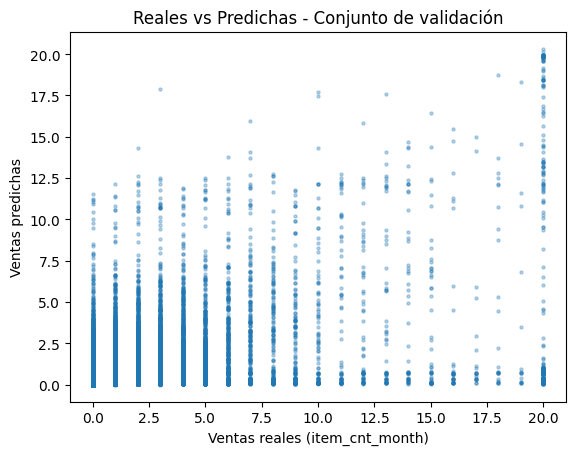

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_valid, y_valid_pred, s=5, alpha=0.3)
plt.xlabel("Ventas reales (item_cnt_month)")
plt.ylabel("Ventas predichas")
plt.title("Reales vs Predichas - Conjunto de validación")
plt.show()


In [ ]:
#Vemos como idelamente se tendrían que comportar de maneria diagonal, pero en valores bajos las predicciones siguen siendo aceptables. 
#En valores altos hay mas volatilidad debido a la gran dispersión y a que hay menos datos para valores más grandes